# VIC: Introduction to Visual Computing - 2021/22
## Assignment 2

**Instructor:** Maria Vakalopoulou
**T.A.:** Joseph Boyd
**Due Date:** March 1, 2022

This is VIC Assignment 2. This time you are to implement a system that outputs object detection bounding boxes of cars in a dashcam videos. You are expected to submit your prediction to a Kaggle challenge at the following link, where you will also find the dataset and further instructions:

https://www.kaggle.com/t/1df65691991d413ab190f6cc4d31b968

You have a set of frames available for training in the `train/` directory, and their bounding boxes in `train.csv`, having format:

```x, y, width, height```

Your task is to produce bounding boxes for each frame in the `test/` directory.  **N.B.** Because of limitations of in-class Kaggle, your final submission file will be of a slightly different format to `train.csv`.

## Evaluation

Submissions are evaluated with respect to the Sørensen–Dice coefficient,

$$DSC = \frac{2|X \cap Y|}{|X| + |Y|},$$

the intersection of the prediction X and the ground truth solution Y over the sum of their parts. The minimum is 0 (no intersection), and the maximum is 1 (perfect overlap). The mean DSC over all test images is your final score. **N.B.** that although the challenge is posed as an object detection problem, it is evaluated as a segmentation problem i.e. X and Y will be binary masks (see below). This is due to some limitations of Kaggle as used in-class mode.

An unspecified 50% split of the test data contributes to a "public leaderboard", with the remaining data contributing to a "private leaderboard", which is not visible until the end of the competition. This is to prevent overfitting to the test data.

## Submitting to Kaggle

Submissions to the Kaggle challenge can be made in the form of a .csv file (see `sample_submission.csv`), consisting of two columns with one row per image:
```
Id,Predicted
test/001.jpg,192425 100 193705 100 ...
test/002.jpg,192425 100 193705 100 ...
test/003.jpg,192425 100 193705 100 ...
...
```
`Id` - the image id, which is the path to the image from the project root--must be exact.

`Predicted` - The [run length encoding](https://en.wikipedia.org/wiki/Run-length_encoding) of the binary mask resulting from your concatenated bounding boxes. It is recommended to use the supplied function `run_length_encoding` to automate this. An example is given in the `Assignment2.ipynb` notebook. **N.B.** If you change the size of the images during your pipeline, be sure to resize your final bounding boxes to  (1280x720).

## Grading

Your work will be evaluated according to the following:

- Solution design (40%): algorithmic complexity, technical innovation, performance (as evaluated on Kaggle). Simple ideas can achieve full marks if they are well-argued and perform well.

- Implementation (40%): code quality, efficiency, clarity of documentation (code should be well commented). You should submit all code required to train/test your pipeline in a `.ipynb` notebook or a set of `.py` file(s).

- Report (~1 page) (20%): Description of pipeline and justification of design choices, results and failure cases. In general, we want to know why you did one thing and not another.

**PLUS** the best 5 leaderboard submissions will receive +1 for the grade of the assignment.

**N.B.** This is an individual assignment. All students are expected to make at least one Kaggle submission and submit their own project code and report.

You should send your assignment by email to maria.vakalopoulou@centralesupelec.fr, the name of the subject of the email should be: VIC\_Assignment2\_name.

## FAQ

**Q:** Can I use external datasets?
**A:** Although we have provided extra training data anyway, we are relaxing the constraint on external datasets. So, yes, you can.

**Q:** Must I code algorithms from scratch?
**A:** You will be graded on the design/implementation of your solution pipeline, which ordinarily will comprise multiple algorithms (e.g. filters, features, machine learning). Unlike the labs and previous assignment, you are not required to code these individual algorithms.

**Q:** Can my pipeline take a long time to run?
**A:** It is acceptable if your training and/or testing takes some hours to run. However, in this case it should be shown that this is fully warranted.

**Q:** Can I use deep learning?
**A:** You are quite free in the design of your solution pipeline. However, **NO DEEP LEARNING APPROACHES ARE ALLOWED**. You should use classic methods to complete this assignment!

In [73]:
import pandas as pd

df_ground_truth = pd.read_csv('./train.csv')
df_ground_truth.head()

,frame_id,bounding_boxes
0,train/001.jpg,0 225 214 317 0 172 345 254 285 240 155 131 70...
1,train/002.jpg,0 254 190 293 0 169 338 271 276 238 160 137 70...
2,train/003.jpg,0 306 59 241 0 155 306 318 235 233 191 149 713...
3,train/004.jpg,0 143 239 298 164 223 240 172 721 293 94 76 57...
4,train/005.jpg,0 217 137 270 55 209 323 208 731 296 99 79 573...


In [74]:
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from skimage.io import imread


H, W = 720, 1280
N = len(df_ground_truth)


def read_frame(df_annotation, frame):
    """Read frames and create integer frame_id-s"""
    file_path = df_annotation[df_annotation.index == frame]['frame_id'].values[0]
    return imread(file_path)

def annotations_for_frame(df_annotation, frame):
    assert frame in df_annotation.index
    bbs = df_annotation[df_annotation.index == frame].bounding_boxes.values[0]

    if pd.isna(bbs): # some frames contain no vehicles
        return []

    bbs = list(map(lambda x : int(x), bbs.split(' ')))
    return np.array_split(bbs, len(bbs) / 4)

def show_annotation(df_annotation, frame):
    img = read_frame(df_annotation, frame)
    bbs = annotations_for_frame(df_annotation, frame)

    fig, ax = plt.subplots(figsize=(15, 12))

    for x, y, dx, dy in bbs:

        rect = patches.Rectangle((x, y), dx, dy, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    ax.imshow(img)
    ax.set_title('Annotations for frame {}.'.format(frame))

def bounding_boxes_to_mask(bounding_boxes, H, W):
    
    """
    Converts set of bounding boxes to a binary mask
    """

    mask = np.zeros((H, W))
    for x, y, dx, dy in bounding_boxes:
        mask[y:y+dy, x:x+dx] = 1

    return mask

def run_length_encoding(mask):

    """
    Produces run length encoding for a given binary mask
    """
    
    # find mask non-zeros in flattened representation
    non_zeros = np.nonzero(mask.flatten())[0]
    padded = np.pad(non_zeros, pad_width=1, mode='edge')
    
    # find start and end points of non-zeros runs
    limits = (padded[1:] - padded[:-1]) != 1
    starts = non_zeros[limits[:-1]]
    ends = non_zeros[limits[1:]]
    lengths = ends - starts + 1

    return ' '.join(['%d %d' % (s, l) for s, l in zip(starts, lengths)])

In [6]:
from ipywidgets import interact, widgets
from IPython.display import display

def f_display(frame_id):
    show_annotation(df_ground_truth, frame_id)

interact(f_display, frame_id=widgets.IntSlider(min=1, max=N, step=1, value=1))

interactive(children=(IntSlider(value=1, description='frame_id', max=2226, min=1), Output()), _dom_classes=('w…

<function __main__.f_display(frame_id)>

## Creating a Kaggle submission file

Suppose we have a set of bounding boxes of format `x, y, width, height`:

In [ ]:
bounding_boxes = [[0, 0, 5, 5], [5, 5, 5, 5]]

For simplicity, let's say they are the same for all test images (yours won't be). Then, we can create a Kaggle submission file like this:

In [ ]:
test_files = sorted(os.listdir('./test/'))

rows = []

for file_name in test_files:

    rle = run_length_encoding(bounding_boxes_to_mask(bounding_boxes, H, W))
    rows.append(['test/' + file_name, rle])

df_prediction = pd.DataFrame(columns=['Id', 'Predicted'], data=rows).set_index('Id')
df_prediction.to_csv('sample_submission.csv')

## Trying stuff out

### Juste SIFT et classer élément de voiture / pas élément de voiture

In [79]:
from cv2 import SIFT_create, imread, drawKeypoints
from tqdm.notebook import tqdm
sift = SIFT_create()

train_files = [os.path.join("train", path) for path in os.listdir('./train/')]

In [82]:
def collect_labeled_features(df_annotation):
    """ 
    Returns SIFT features for all images labeled as "part of a car" or not
    The labeling is done thanks to the keypoints and bounding boxes
    """
    features, labels = [], []

    for frame in tqdm(range(1, len(df_annotation)+1)):
        image = read_frame(df_annotation, frame)
        bbs = annotations_for_frame(df_annotation, frame)
        kp, f = sift.detectAndCompute(image, None)

        features += f.tolist()
        labels += label_keypoints(kp, bbs).tolist()

    return features, labels

def label_keypoints(keypoints, bounding_boxes):
    coords = np.array([kp.pt for kp in keypoints])

    low_bbs = np.array([bb[0:2] for bb in bounding_boxes]) # shape = (M, 2)
    high_bbs = low_bbs + np.array([bb[2:] for bb in bounding_boxes])

    is_coord_good = (low_bbs[np.newaxis, ...] <= coords[:, np.newaxis, :]) & (coords[:, np.newaxis, :] <= high_bbs[np.newaxis, ...]) # (N, M, 2)

    is_kp_good = (is_coord_good[:, :, 0] & is_coord_good[:, :, 1]).any(1)

    return is_kp_good.astype(int)


In [84]:
features, labels = collect_labeled_features(df_ground_truth)

  0%|          | 0/2226 [00:00<?, ?it/s]

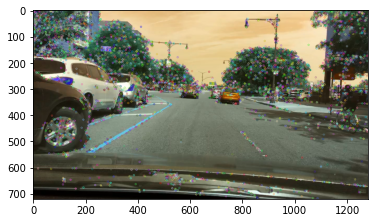

In [11]:
image = imread(train_files[0])

keypoints, features  = sift.detectAndCompute(image, None)

image_w_keypoints = drawKeypoints(image, keypoints, image)

plt.imshow(image_w_keypoints)

In [70]:
bb1 = 100, 100, 50, 50
bb2 = 300, 300, 50, 50
bb3 = 900, 200, 100, 100
M = 3

low_bbs = np.array([bb1[0:2], [*bb2[0:2]], [*bb3[0:2]]]) # shape = (M, 2)
high_bbs = low_bbs + np.array([[*bb1[2:]], [*bb2[2:]], [*bb3[2:]]])

coords = np.array([kp.pt for kp in keypoints]) # shape = (N, 2)

is_good = (low_bbs[np.newaxis, ...] <= coords[:, np.newaxis, :]) & (coords[:, np.newaxis, :] <= high_bbs[np.newaxis, ...]) # (N, M, 2)

is_kp_good = (is_good[:, :, 0] & is_good[:, :, 1]).any(1)

good_coords = coords[is_kp_good]

good_coords.mean(0)

array([747.49676332, 232.68629546])

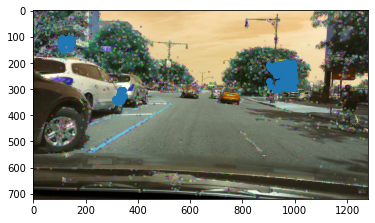

In [69]:
plt.imshow(image)
plt.scatter(good_coords[:, 0], good_coords[:, 1])